In [4]:
"""
So I created 100 random datasets in Data Generator of between 50-100 points and 2-10 dimensional X points
and sigma of between 0-1. You can change those values and make new datasets if you want easily in the last box of 
Data Generator.

The second box here is my solve least squares, ridge regression, and ALS code.
The third box loads the datasets (change the 100 to a different value if you change the number of datasets) with the 
first function. It creates many lambda values (right now 100, so we have a 100x100 matrix overall). get_points 
randomly chooses approximately #rows*#cols*p + #rows + #cols points as training data and 
#rows*#cols*q + #rows + #cols points as test data. get_MSE gives the 
MSE for that dataset and lambda value. generate_data calculates the MSE for all of those and
formats it so ALS can run.

Things to mess around with: rank, as currently it's using 2. p and q are the approximate percentage of the matrix
that is filled. MSE_iters is how precise the MSE is. ALS_lam is how regularized the ALS is.
"""

"\nSo I created 100 random datasets in Data Generator of between 50-100 points and 2-10 dimensional X points\nand sigma of between 0-1. You can change those values and make new datasets if you want easily in the last box of \nData Generator.\n\nThe second box here is my solve least squares, ridge regression, and ALS code.\nThe third box loads the datasets (change the 100 to a different value if you change the number of datasets) with the \nfirst function. It creates many lambda values (right now 100, so we have a 100x100 matrix overall). get_points \nrandomly chooses approximately #rows*#cols*p + #rows + #cols points as training data and \n#rows*#cols*q + #rows + #cols points as test data. get_MSE gives the \nMSE for that dataset and lambda value. generate_data calculates the MSE for all of those and\nformats it so ALS can run.\n\nThings to mess around with: rank, as currently it's using 2. p and q are the approximate percentage of the matrix\nthat is filled. MSE_iters is how precise t

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [16]:
def solve_ls(X, y):
    inv = np.linalg.inv(np.dot(X.T, X))
    a = np.dot(inv, X.T)
    return np.dot(a, y)

def solve_rr(X, y, lam):
    inv = np.linalg.inv(np.dot(X.T, X) + lam * np.identity(np.shape(X)[1]))
    a = np.dot(inv, X.T)
    return np.dot(a, y)

#John's ALS code
def ALS(data_train, data_test, k=2, lam=0.02, max_iter=100, verbose = False):
    '''
    data_train and data_test are lists of tuples (row, column, MSE)
    these need to be integers so we need to map each dataset and lambda value to an integer (MSE need not be integer)
    
    k is rank
    lam is the regularizer on the least squares call in each step
    
    my code also has offsets b_u and b_v
    the prediction for entry (a, i) is (b_u[a] + b_v[i] + np.dot(u[a].T, v[i])[0][0])
    '''
    # size of the problem
    n = max(d[0] for d in data_train)+1 # datasets
    m = max(d[1] for d in data_train)+1 # lambda values
    # which entries are set in each row and column and the MSE
    us_from_v = [[] for i in range(m)]  # II (i-index-set)
    vs_from_u = [[] for a in range(n)]  # AI (a-index set)
    for (a, i, r) in data_train:
        us_from_v[i].append((a, r))
        vs_from_u[a].append((i, r))
    # Initial guesses for u, b_u, v, b_v
    # Note that u and v are lists of column vectors (rows of U, V).
    u, b_u, v, b_v = ([np.random.normal(1/k, size=(k,1)) for a in range(n)],
          np.zeros(n),
          [np.random.normal(1/k, size=(k,1)) for i in range(m)],
          np.zeros(m))
    for itr in range(max_iter):
        if itr%5 == 0 and verbose:
            print(itr)
        for i in range(len(u)): #run ls on u
            X_mat = np.array([np.append(np.array([1]), v[a[0]].T[0]) for a in vs_from_u[i]])
            y_vec = np.array([[a[1] - b_v[a[0]]] for a in vs_from_u[i]])
            if len(X_mat) > 0:
                sol = solve_rr(X_mat, y_vec, lam)
                b_u[i] = sol[0]
                u[i] = sol[1:]
        for j in range(len(v)): #run ls on v
            X_mat = np.array([np.append(np.array([1]), u[a[0]].T[0]) for a in us_from_v[j]])
            y_vec = np.array([[a[1] - b_u[a[0]]] for a in us_from_v[j]])
            if len(X_mat) > 0:
                sol = solve_rr(X_mat, y_vec, lam)
                b_v[j] = sol[0][0]
                v[j] = sol[:][1:]
            
    # TODO: Evaluate using some error metric measured on test set
    error = 0
    count = 0
    for (a, i, r) in data_test:
        count += 1
        error += (b_u[a] + b_v[i] + np.dot(u[a].T, v[i])[0][0] - r) ** 2
    error = error / count
    return (u, b_u, v, b_v, error)

In [17]:
def load_datasets():
    dataset_dic = {}
    for i in range(100):
        X_df = pd.read_csv('gendata/example_dataset' + str(i + 1) + '.csv')
        dataset_dic[i] = X_df
    return dataset_dic

lambda_dic = {lamb + 60: 10 ** (-.05 * lamb) for lamb in range(-60, 40)}
  
def get_points(m, n, p, q):
    train_points = set()

    for i in range(m):
        j = np.random.randint(0, n)
        train_points.add((i, j))
    for j in range(n):
        i = np.random.randint(0, m)
        if (i, j) not in train_points:
            train_points.add((i, j))
    for i in range(m):
        for j in range(n):
            if np.random.random() < p:
                if (i, j) not in train_points:
                    train_points.add((i, j))

    test_points = set()

    for i in range(m):
        for j in range(n):
            if np.random.random() < q:
                if (i, j) not in train_points:
                    test_points.add((i, j))
                    
    return train_points, test_points

def get_MSE(X_df, lam, iters = 1, size = 0.5):
    MSE = 0
    for _ in range(iters):
        train, test = train_test_split(X_df, test_size=size)
        X_train, Y_train = np.array(train.drop('Y', axis=1)), np.transpose(np.array([train['Y']]))
        X_1 = np.hstack((np.ones(shape = (len(X_train), 1)), X_train))
        sol = solve_rr(X_1, Y_train, lam)
        X_test, Y_test = np.array(test.drop('Y', axis=1)), np.transpose(np.array([test['Y']]))
        X_2 = np.hstack((np.ones(shape = (len(X_test), 1)), X_test))
        MSE += np.linalg.norm(X_2@sol - Y_test) / len(X_2)
    return MSE / iters

def generate_data(dataset_dic, lambda_dic, points, iters = 1, size = 0.5):
    data = []
    for (i, j) in points:
        MSE = get_MSE(dataset_dic[i], lambda_dic[j], iters, size)
        data.append((i, j, MSE))                    
    return data     

In [21]:
def run_ALS(p=0.05, q=0.1, MSE_iters=10, rank = 2, ALS_lam = 0.02, ALS_iters = 100, verbose = False):
    dataset_dic = load_datasets()
    if verbose: print('loaded datasets')
    train_pts, test_pts = get_points(len(dataset_dic), len(lambda_dic), p = p, q = q)
    if verbose: print('generated points')
    data_train = generate_data(dataset_dic, lambda_dic, train_pts, iters = MSE_iters)
    if verbose: print('generated train list')
    data_test = generate_data(dataset_dic, lambda_dic, test_pts, iters = MSE_iters)
    if verbose: print('generated test list')
    u, b_u, v, b_v, error = ALS(data_train, data_test, k=rank, lam=ALS_lam, max_iter=ALS_iters)
    if verbose: print('finished ALS. Error {}'.format(error))
    return error


In [23]:
ranks = [i for i in range(2, 10)]
als_lams = [2*i/100. for i in range(0, 10)]
errors = []

for r in ranks:
    temp = []f
    for l in als_lams:
        err = run_ALS(rank = r, ALS_lam = l)
        print("Error with rank {} and als_lam {} is {}".format(r, l, err))
        temp.append(err)
    errors.append(temp)

Error with rank 2 and als_lam 0.0 is 19121.143571842666
Error with rank 2 and als_lam 0.02 is 0.0005436655236343179
Error with rank 2 and als_lam 0.04 is 0.0006301680461849621
Error with rank 2 and als_lam 0.06 is 0.0008248270353622123
Error with rank 2 and als_lam 0.08 is 0.0007097211324746214
Error with rank 2 and als_lam 0.1 is 0.0008363401906133342
Error with rank 2 and als_lam 0.12 is 0.0012329358008907338
Error with rank 2 and als_lam 0.14 is 0.0013159234879363054
Error with rank 2 and als_lam 0.16 is 0.0011029406844145246
Error with rank 2 and als_lam 0.18 is 0.0012523162404151293
Error with rank 3 and als_lam 0.0 is 7.903798942422541e+41
Error with rank 3 and als_lam 0.02 is 0.0005751785397961071
Error with rank 3 and als_lam 0.04 is 0.0009052526312427642
Error with rank 3 and als_lam 0.06 is 0.0010542072147205436
Error with rank 3 and als_lam 0.08 is 0.000853092116854198
Error with rank 3 and als_lam 0.1 is 0.0010895942969095145
Error with rank 3 and als_lam 0.12 is 0.00129601

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in double_scalars


Error with rank 7 and als_lam 0.0 is inf
Error with rank 7 and als_lam 0.02 is 0.0005820397768904043
Error with rank 7 and als_lam 0.04 is 0.0005441272123401879
Error with rank 7 and als_lam 0.06 is 0.0009471543260609829
Error with rank 7 and als_lam 0.08 is 0.0008226216433239703
Error with rank 7 and als_lam 0.1 is 0.0009406002045681447
Error with rank 7 and als_lam 0.12 is 0.0013086029246397789
Error with rank 7 and als_lam 0.14 is 0.0014162159392216954
Error with rank 7 and als_lam 0.16 is 0.0014104904300491037
Error with rank 7 and als_lam 0.18 is 0.001678408979585491
Error with rank 8 and als_lam 0.0 is inf
Error with rank 8 and als_lam 0.02 is 0.0008370370690508126
Error with rank 8 and als_lam 0.04 is 0.0007921634863170435
Error with rank 8 and als_lam 0.06 is 0.0007832260962429133
Error with rank 8 and als_lam 0.08 is 0.0010646985073703868
Error with rank 8 and als_lam 0.1 is 0.0011244350596085163
Error with rank 8 and als_lam 0.12 is 0.0010847663697065482
Error with rank 8 and

In [9]:
error

0.0009675726296254285

Text(0.5,1,'MSE of ALS Matrix estimation varying Ranks and ALS_Lambda')

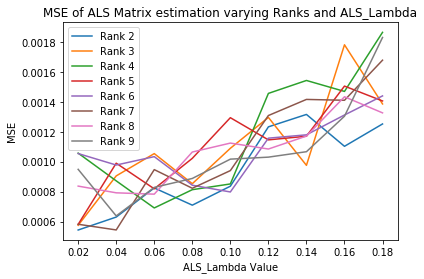

In [30]:
for i,  values in enumerate(errors):
    rank = ranks[i]
    corr_errs = values[1:]
    plt.plot(als_lams[1:], corr_errs, label='Rank {}'.format(rank))

plt.legend()
plt.xlabel('ALS_Lambda Value')
plt.ylabel('MSE')
plt.title('MSE of ALS Matrix estimation varying Ranks and ALS_Lambda')

In [28]:
errors[0]

[19121.143571842666,
 0.0005436655236343179,
 0.0006301680461849621,
 0.0008248270353622123,
 0.0007097211324746214,
 0.0008363401906133342,
 0.0012329358008907338,
 0.0013159234879363054,
 0.0011029406844145246,
 0.0012523162404151293]